In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers

We are loading fashion mnist data .The generator will generate fashion items resembling the fashion MNIST data.

In [2]:
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

train_images.shape

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(60000, 28, 28)

Reshaping the images to add one more dimension i.e Channel. As the images aregray-scale so Channel dimension will be 1. Also,Normalizing the images to [-1,1]because the generator’s final layer activation uses tanh

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

train_images.shape

(60000, 28, 28, 1)

In [4]:
train_images[56782, :10, :10]

array([[[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  1.],
        [  0.],
        [  0.],
        [  0.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.],
        [  0.],
        [ 74.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.],
        [  0.],
        [ 77.],
        [207.]],

       [[  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.],
        [124.],
        [176.],
        [192.],
        [180.]],

       [[  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [ 88.],
        [207.],
        [184.],
        [183.],
        [182.]],

       [[  0.],
        [  0

In [5]:
train_images = (train_images - 127.5) / 127.5

train_images[56782, :10, :10]

array([[[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-0.99215686],
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-1.        ],
        [-1.        ]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.41960785]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.39607844],
        [ 0.62352943]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
   

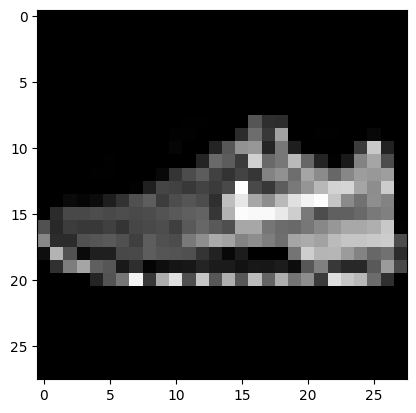

In [6]:
plt.imshow(train_images[2567].squeeze(), cmap = 'gray')

Training set is prepared by dividing the whole data into batches and shuffling it.

In [7]:
buffer_size = 60000
batch_size = 128

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

Both the generator and discriminator are defined using the Keras Sequential API.

The generator uses tf.keras.layers.Dense layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then using Relu activations for each Dense layer.Note that activation in final layer is tanh which outputs in the range -1 to 1. we reshape the 784-d tensor to (Batch Size, 28, 28, 1) using layers.Reshape function

In [9]:
def generator_model():

    model = tf.keras.Sequential()
    model.add(layers.Dense(64, input_dim = 100))
    model.add(layers.ReLU())

    model.add(layers.Dense(128))
    model.add(layers.ReLU())

    model.add(layers.Dense(256))
    model.add(layers.ReLU())

    model.add(layers.Dense(784, activation = 'tanh'))
    model.add(layers.Reshape((28, 28, 1)))

    return model

In [27]:
# Building the generator model and summary is obtained

generator = generator_model()

generator.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 784)                 │         201,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 249,296 (973.81 KB)

 Trainable params: 249,296 (973.81 KB)

 Non-trainable params: 0 (0.00 B)

Using the untrained generator to create an random gray scale image.

In [11]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training = False)

generated_image.shape

TensorShape([1, 28, 28, 1])

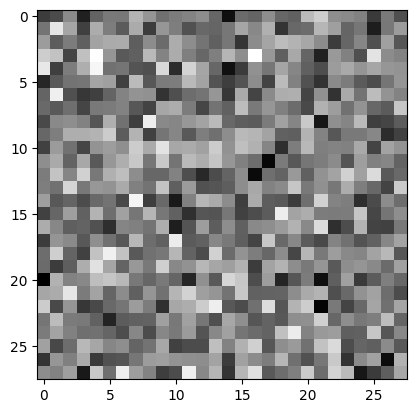

In [12]:
plt.imshow(generated_image[0, :, :, 0], cmap = 'gray')

Note that the discriminator is a binary classifier, consisting only of fully-connected layers. So, the discriminator expects a tensor of shape (BatchSize, 28, 28, 1). We are flattening out input to feed it into Denselayers. Each dense layer is having activation as LeakyRelu followed by drop out layers The final layer has the sigmoid activation function, which squashes the output value between 0 (fake) and 1 (real).Note that we can also leave the last layer without sigmoid activation and use_logits=True in Binary Cross entropy function(which is recommended).

In [13]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape = (28, 28, 1)))
    model.add(layers.Flatten())

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model

In [28]:
# Building the discriminator model and summary is obtained

discriminator = discriminator_model()

discriminator.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 242,177 (946.00 KB)

 Trainable params: 242,177 (946.00 KB)

 Non-trainable params: 0 (0.00 B)

Here We are using the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output values > 0.5 for real images, and values <0.5 for fake images.

In [15]:
discriminator = discriminator_model()
output = discriminator(generated_image)
print (output)

tf.Tensor([[0.47509274]], shape=(1, 1), dtype=float32)


Now We are defining loss functions. In this case it is Binary Cross entropy as target is real or fake images

In [16]:
bce = tf.keras.losses.BinaryCrossentropy()

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [17]:
def discriminator_loss(real_output, fake_output):

    real_loss = bce(tf.ones_like(real_output), real_output)

    fake_loss = bce(tf.zeros_like(fake_output), fake_output)

    total_loss = real_loss + fake_loss

    return total_loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [18]:
def generator_loss(fake_output):

    gen_loss = bce(tf.ones_like(fake_output), fake_output)

    return gen_loss

The discriminator and the generator optimizers are different since two networks would be trained separately.



In [19]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001 )
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001 )

In [29]:
# demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

We are using tf.function This annotation causes the function to be "compiled".

In [21]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))

Notice training is set to False. This is so all layers run in inference mode (batchnorm). Function for generating and plotting images is defined

In [23]:
def generate_and_plot_images(model, epoch, test_input):

    predictions = model(test_input, training = False)

    fig = plt.figure(figsize = (8, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        pred = (predictions[i, :, :, 0] + 1) * 127.5
        pred = np.array(pred)
        plt.imshow(pred.astype(np.uint8), cmap = 'gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [24]:
def train(dataset, epochs):

    gen_loss_list = []
    disc_loss_list = []

    real_score_list =[]
    fake_score_list =[]
    for epoch in tqdm(range(epochs)):
        start = time.time()
        num_batches = len(dataset)

        print(f'Training started with  epoch {epoch + 1} with {num_batches} batches...')

        total_gen_loss = 0
        total_disc_loss = 0

        for batch in dataset:
            generator_loss, discriminator_loss, real_score, fake_score = train_step(batch)
            total_gen_loss += generator_loss
            total_disc_loss += discriminator_loss

        mean_gen_loss = total_gen_loss / num_batches
        mean_disc_loss = total_disc_loss / num_batches

        print('Losses after epoch %5d: generator %.3f, discriminator %.3f, real_score %.2f%%, fake_score %.2f%%'  %
              (epoch + 1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))

        generate_and_plot_images(generator, epoch + 1, seed)

        gen_loss_list.append(mean_gen_loss)
        disc_loss_list.append(mean_disc_loss)
        real_score_list.append(real_score)
        fake_score_list.append(fake_score)

        if (epoch + 1) % 10 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


    return  gen_loss_list, disc_loss_list, real_score_list, fake_score_list

Finally, it’s time to train our GAN model in Tensorflow. Taking the train_dataset and epochs as the parameters, the train function calls the train_step function, at every new batch.At the beginning of the training, the generated images look like random noise. As training progresses, the generated images will look more real.

In [25]:
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list = train(train_dataset, epochs = epochs)

Output hidden; open in https://colab.research.google.com to view.

Plotting visualisations for Losses and Scores

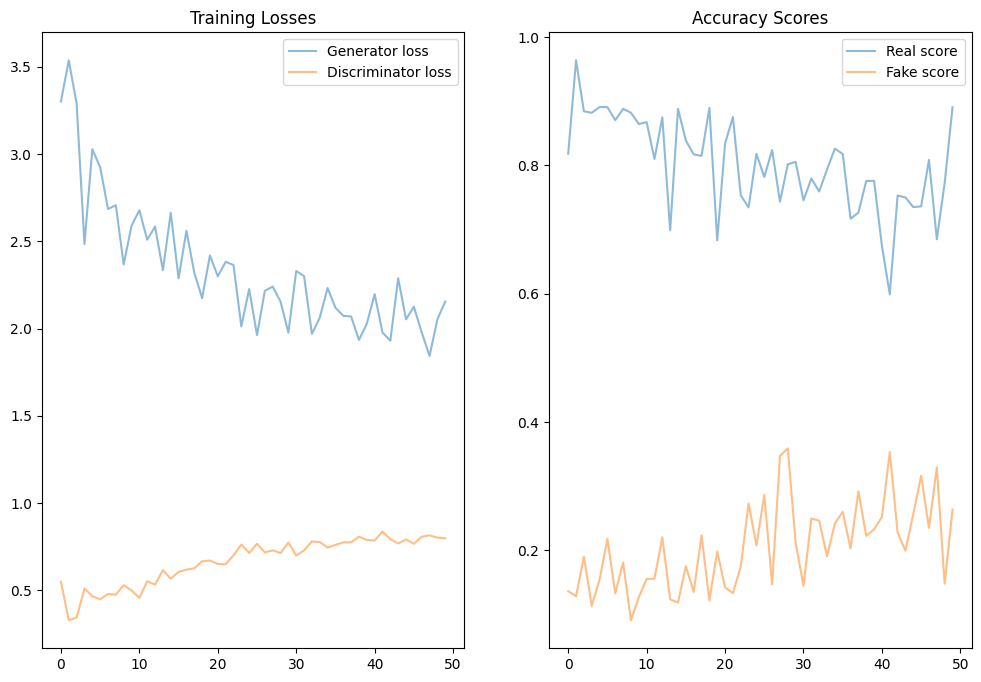

In [26]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (12, 8))

ax1.plot(gen_loss_epochs, label = 'Generator loss', alpha = 0.5)
ax1.plot(disc_loss_epochs, label = 'Discriminator loss', alpha = 0.5)
ax1.legend()

ax1.set_title('Training Losses')
ax2.plot(real_score_list, label = 'Real score', alpha = 0.5)
ax2.plot(fake_score_list, label = 'Fake score', alpha = 0.5)
ax2.set_title('Accuracy Scores')

ax2.legend()